In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import struct
import random
import pandas as pd

In [2]:
def byteToPixel(file, width,length):
    stringcode = '>'+'B' * len(file)
    data = array(struct.unpack(stringcode, file))
    data = data.reshape(int(len(file)/(width*length)),width*length,1)/255
    return data

In [3]:
def load_data(filename, labelname, width, length):
    with open(filename, 'rb') as f:
        bytefile = f.read()
    f.close()
    pixelfile = byteToPixel(bytefile, width,length)
    
    file = open(labelname,"r")
    labelfile = []
    for line in file:
        current = line.split()
        results = list(map(int, current))
        results = array(list(map(lambda x:[x], results)))
        labelfile.append(results)
    
    data = list(zip(pixelfile, labelfile))
    return data

In [93]:
def confusionMatrix(result,outterlayer):
    Matrix = np.zeros((outterlayer,outterlayer))
    for (x,y) in result:
        Matrix[np.argmax(y)][np.argmax(x)] += 1
    Matrix = pd.DataFrame(Matrix)
    return Matrix

In [6]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))


In [7]:
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [113]:
class Network(object):

    def __init__(self, sizes):
        self.num_hlayers = len(sizes)-2
        self.sizes = sizes
        self.biases = []
        self.weights = []
        
    def create_wb(self, weights,biases):
        self.biases = biases
        self.weights = weights
    
    def return_wb(self):
        return self.weights, self.biases

    def feedforward(self, activation):
        for b, w in zip(self.biases, self.weights):
            activation = sigmoid(np.dot(w, activation)+b)
        return activation
    
    def pick_mini_batches(self,training_data,mini_batch_size):
        n = len(training_data)
        random.shuffle(training_data)
        mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
        return mini_batches
        
    def training_network(self, training_data,mini_batch_size,learning_rate):
            mini_batches = self.pick_mini_batches(training_data,mini_batch_size)
            for mini_batch in mini_batches:
                self.changed_mini_batch(mini_batch, learning_rate)
    
    def changed_mini_batch(self, mini_batch, learning_rate):
        sum_of_b = [np.zeros(b.shape) for b in self.biases]
        sum_of_w = [np.zeros(w.shape) for w in self.weights]
        
        for activation, label in mini_batch:
            
            delta_one_b, delta_one_w = self.backward_prop(activation, label)
            
            sum_of_b = [sb+dob for sb, dob in zip(sum_of_b, delta_one_b)]
            sum_of_w = [sw+dow for sw, dow in zip(sum_of_w, delta_one_w)]
            
        self.weights = [w-(learning_rate/len(mini_batch))*sw for w, sw in zip(self.weights, sum_of_w)]
        self.biases = [b-(learning_rate/len(mini_batch))*sb for b, sb in zip(self.biases, sum_of_b)]
    
    def backward_prop(self,x, y):
        change_b = [np.zeros(b.shape) for b in self.biases]
        change_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activation_collection = [activation] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activation_collection.append(activation)
            
        #Calculate backward from label y
        delta = self.cost_derivative(activation_collection[-1], y) * sigmoid_prime(zs[-1])
        change_b[-1] = delta
        change_w[-1] = np.dot(delta, activation_collection[-2].transpose())

        for layer in range(2, self.num_hlayers+2):
            z = zs[-layer]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            change_b[-layer] = delta
            change_w[-layer] = np.dot(delta, activation_collection[-layer-1].transpose())
        return change_b, change_w
    
    def evaluate(self, test_data):

        test_results = [(self.feedforward(x), y)for (x, y) in test_data]
        result = 0
        for (x, y) in test_results:
            if np.argmax(x) == np.argmax(y):
                result += 1
        mse = 0
        for item in test_results:
            temp = sum((item[0] - item[1])**2)/len(item[1])
            mse = temp+mse
        mse = mse/len(test_results)
        
        return result, mse, test_results
        
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
    def evaluate_epochs(self,training_data,mini_batch_size,learning_rate, test_data=None):
        if test_data is not None:
            n_test = len(test_data)
        temp_diff = 0
        a_mse = 0
        b_mse = 0
        j = 0
        result_epochs = []
        result_mse = []
        result_mse_different = []
        while True:
            self.training_network(training_data,mini_batch_size,learning_rate)
            if test_data is not None:
                result ,mse,test_results = self.evaluate(test_data)
                result_epochs.append(result)
                result_mse.append(mse)
                a_mse = mse
                if temp_diff <0.0001 and temp_diff != 0: ##same data or overshoot
                    return test_results, result_epochs, result_mse, result_mse_different
                else:
                    temp_diff = abs(a_mse - b_mse)
                    if temp_diff == a_mse:
                        temp_diff = None
                    result_mse_different.append(temp_diff)
                    b_mse = a_mse
                    print ("Epoch " + str(j)+ ": "+ str(result)+' / ' + str(n_test) + '   ' + str(mse)+'   ' \
                           + str(temp_diff))
                    if temp_diff is None:
                        temp_diff = 2
            else:
                break
                print ("Epoch" + str(j) +  "complete")

            j+=1

In [4]:
train_image = 'train_images.raw'
test_image = 'test_images.raw'
train_label = "train_labels.txt"
test_label = "test_labels.txt"
contents_train = load_data(train_image,train_label,28,28)
contents_test = load_data(test_image,test_label,28,28)

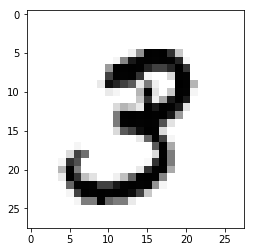

In [5]:
k = contents_train[0][0].reshape(28,28)
plt.imshow(k, cmap='Greys',  interpolation='nearest')

In [99]:
sizes = [784,50,50,5]
net = Network(sizes)
print (net.num_hlayers)

2


In [100]:
net.create_wb([np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])],[np.random.randn(y, 1) for y in sizes[1:]])


In [101]:
result, result_epochs, result_mse, result_mse_different= net.evaluate_epochs\
(contents_train,100,0.5, test_data=contents_test)

Epoch 0: 1685 / 2561   [0.09784545]   None
Epoch 1: 2183 / 2561   [0.05080502]   [0.04704044]
Epoch 2: 2295 / 2561   [0.03785714]   [0.01294788]
Epoch 3: 2343 / 2561   [0.03160148]   [0.00625566]
Epoch 4: 2361 / 2561   [0.02784894]   [0.00375254]
Epoch 5: 2382 / 2561   [0.02538612]   [0.00246282]
Epoch 6: 2397 / 2561   [0.02339457]   [0.00199156]
Epoch 7: 2411 / 2561   [0.02189221]   [0.00150236]
Epoch 8: 2415 / 2561   [0.02084806]   [0.00104415]
Epoch 9: 2425 / 2561   [0.01980458]   [0.00104348]
Epoch 10: 2430 / 2561   [0.01900556]   [0.00079902]
Epoch 11: 2429 / 2561   [0.01825121]   [0.00075435]
Epoch 12: 2430 / 2561   [0.01783319]   [0.00041802]
Epoch 13: 2438 / 2561   [0.01718763]   [0.00064555]
Epoch 14: 2438 / 2561   [0.01683877]   [0.00034886]
Epoch 15: 2446 / 2561   [0.01623534]   [0.00060343]
Epoch 16: 2448 / 2561   [0.01606061]   [0.00017473]
Epoch 17: 2450 / 2561   [0.01568068]   [0.00037993]
Epoch 18: 2450 / 2561   [0.01538461]   [0.00029607]
Epoch 19: 2454 / 2561   [0.015

In [94]:
confusionMatrix(result,5)

,0,1,2,3,4
0,452.0,1.0,3.0,0.0,4.0
1,0.0,561.0,6.0,4.0,0.0
2,8.0,2.0,486.0,24.0,10.0
3,5.0,2.0,9.0,482.0,2.0
4,3.0,3.0,10.0,1.0,483.0


In [106]:
result_epochs2 = [x / 2561 for x in result_epochs]

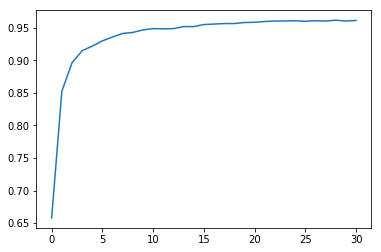

In [112]:
plt.plot(result_epochs2)
plt.show()